## Table of Contents

1. [Objective](#section1)<br> 
2. [Import Packages](#section2)<br> 
3. [Establish connection with MongoDB and Read JSON data](#section3)<br> 
4. [Extracting column names and store the data in the Dataframe](#section4)<br> 
5. [Data Pre-Processing](#section5)<br>      
    - 5.1 [Remove Irrelevant Columns](#section50101)<br>      
    - 5.2 [Handle missing values](#section50102)<br>
    - 5.3 [Handle missing data for range of values](#section50103)<br>
6. [Data Post-Processing](#section6) 
    - 6.1 [Update Column Names](#section601)<br>
    - 6.2 [Save the Dataframe in a csv file ](#section602)<br>
7. [Loading the Data to Postgresql Database](#section7)
  - 7.1 [Establish Connection and Create Database in PostgreSQL](#section701)<br>
  - 7.2 [Create Table Schema in PostgreSQL](#section702)<br> 
  - 7.3 [Create Table using created schema](#section703)<br>
  - 7.4 [Insert Data into table ](#section704)<br>
  - 7.5 [Selecting Data from Postgresql and saving it in a Dataframe](#section705)<br>
8. [Visualization ](#section8)
  - 8.1 [Division of Anxiety and Depressive disorder against Race ](#section801)<br>
  - 8.2 [Mental Health v/s Age Group ](#section802)<br>
  - 8.3 [Mental Health Based on Age and Ethnicity ](#section803)<br>
  - 8.4 [Mental Health w.r.t. Education Level ](#section804)<br>
  - 8.5 [Mental Health w.r.t US states](#section805)<br>
  - 8.6 [Mental Health Based on Gender ](#section806)<br>


<a id=section1></a>
## 1. Objective
The study aims to guage the impact of COVID-19 pandemic on the mental well-being of people for different indicators such as Anxiety and Depressive disorders with respect to various subgroups like age, sex, ethnicity, education and state on American households.

<a id=section2></a>
## 2. Import Packages

In [65]:
from pymongo import MongoClient
import json
import pandas as pd
import numpy as np
import psycopg2
import csv
import pandas.io.sql as sqlio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec as gs
import plotly as pl 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

<a id=section3></a>
## 3. Establish connection with MongoDB and Read JSON data

In [66]:
#Establish connection with MongoDB
try :
    client = MongoClient('localhost', 27017)
    print("Connection successful!")
except :
    print("Connection unsuccessful!")
#Establish connection
# client = MongoClient('localhost', 27017)
# db = client['mentalStateDatabase']
# collection = db['mental+StateCollection']

Connection successful!


In [67]:
#Read Json data
filepath = r'C:\Users\Pratiksha Chate\Desktop\Books\DAP\Project\mental_state.json'     #read JSON data
try :
    with open(filepath) as file:
        file_data = json.load(file)    #load json dada
    print("File loaded!")
except :
    print("Unable to open the file!")
finally :
    file.close()    #file closed
    print("File closed!")

File loaded!
File closed!


In [68]:
try :
    db = client['mentalStateDatabase']    # Create DB with DB name as mentalStateDatabase
    collection = db['mentalStateCollection']    #Create collection : mentalStateCollection to store JSON data
    collection.insert_one(file_data)          #insert the loaded file into collection
except :
    print("Cannot access DB or Collection, unable to insert file!") #Error
finally :
    client.close()    #Close connection

<a id=section4></a>
## 4. Extracting column names and store the data in the Dataframe 

In [69]:
getData = pd.DataFrame(list(collection.find()))    #storing the data into the dataframe

columns = [] #Creating an empty list to store column names
#Fetching Column names details from data stored in MongoDB using for loop 
for data in getData["meta"]:
    for column in data['view']['columns']:
        columnName = column['name']
        if columnName not in columns:
            columns.append(columnName)
        
print(columns) 

['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at', 'updated_meta', 'meta', 'Indicator', 'Group', 'State', 'Subgroup', 'Phase', 'Time Period', 'Time Period Label', 'Time Period Start Date', 'Time Period End Date', 'Value', 'Low CI', 'High CI', 'Confidence Interval', 'Quartile Range']


In [70]:
mentalStateData = pd.DataFrame(getData["data"][0], columns = columns)    #Creating data frame to store data in the respective columns
mentalStateData.head()      # Viewing the data once all the columns are stored

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,Indicator,Group,...,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,row-uvus~fkd7~5n8d,00000000-0000-0000-FF4C-9B7FEAB1EE38,0,1616607254,None,1616607254,None,{ },Symptoms of Depressive Disorder,National Estimate,...,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.5,22.7,24.3,22.7 - 24.3,None
1,row-8dds_jtbr-8tje,00000000-0000-0000-2640-ABAADAB0B6E9,0,1616607254,None,1616607254,None,{ },Symptoms of Depressive Disorder,By Age,...,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,32.7,30.2,35.2,30.2 - 35.2,None
2,row-5tu2-vhsx.a848,00000000-0000-0000-589D-42A97521E660,0,1616607254,None,1616607254,None,{ },Symptoms of Depressive Disorder,By Age,...,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,25.7,24.1,27.3,24.1 - 27.3,None
3,row-3wjv.7nc8-y6cw,00000000-0000-0000-1F5D-8882E93DB578,0,1616607254,None,1616607254,None,{ },Symptoms of Depressive Disorder,By Age,...,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,24.8,23.3,26.2,23.3 - 26.2,None
4,row-x9gt~7ct7.tsgh,00000000-0000-0000-DBFD-0078E1D25624,0,1616607254,None,1616607254,None,{ },Symptoms of Depressive Disorder,By Age,...,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.2,21.5,25,21.5 - 25.0,None


<a id=section5></a>
## 5. Data Pre-Processing

<a id=section50101></a>
### 5.1  Remove Irrelevant Columns
Identifying and Deleting the columns that are not relevant.

In [72]:
#Dropping the first eight columns as they are relevant only when dealing with json files.
mentalStateData.drop(mentalStateData.columns[0:8], axis = 1, inplace = True)
pd.DataFrame().from_dict(mentalStateData)
mentalStateData

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.5,22.7,24.3,22.7 - 24.3,None
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,32.7,30.2,35.2,30.2 - 35.2,None
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,25.7,24.1,27.3,24.1 - 27.3,None
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,24.8,23.3,26.2,23.3 - 26.2,None
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.2,21.5,25,21.5 - 25.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Virginia,Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,34.3,30.5,38.2,30.5 - 38.2,33.4-36.0
5570,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Washington,Washington,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,37.3,34.1,40.6,34.1 - 40.6,36.1-38.7
5571,Symptoms of Anxiety Disorder or Depressive Dis...,By State,West Virginia,West Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,43.5,36.6,50.6,36.6 - 50.6,38.8-47.2
5572,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Wisconsin,Wisconsin,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,31.7,27,36.6,27.0 - 36.6,25.9-33.3


<a id=section50102></a>
### 5.2  Handle missing values
Identify the missing values in each column and replace with median

In [73]:
#Counting the missing values in each column
missing = pd.DataFrame(mentalStateData.isnull().sum())
print(missing)

                           0
Indicator                  0
Group                      0
State                      0
Subgroup                   0
Phase                      0
Time Period                0
Time Period Label          0
Time Period Start Date     0
Time Period End Date       0
Value                    114
Low CI                   114
High CI                  114
Confidence Interval      114
Quartile Range          1596


In [74]:
#Replacing the missing values of columns Value, Low CI, High CI with median value
mentalStateData['Value'] = mentalStateData['Value'].fillna(mentalStateData['Value'].median(axis=0))
mentalStateData['Low CI'] = mentalStateData['Low CI'].fillna(mentalStateData['Low CI'].median(axis=0))
mentalStateData['High CI'] = mentalStateData['High CI'].fillna(mentalStateData['High CI'].median(axis=0))

In [75]:
missing = pd.DataFrame(mentalStateData.isnull().sum())
print(missing)
mentalStateData

                           0
Indicator                  0
Group                      0
State                      0
Subgroup                   0
Phase                      0
Time Period                0
Time Period Label          0
Time Period Start Date     0
Time Period End Date       0
Value                      0
Low CI                     0
High CI                    0
Confidence Interval      114
Quartile Range          1596


,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.5,22.7,24.3,22.7 - 24.3,None
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,32.7,30.2,35.2,30.2 - 35.2,None
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,25.7,24.1,27.3,24.1 - 27.3,None
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,24.8,23.3,26.2,23.3 - 26.2,None
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.2,21.5,25,21.5 - 25.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Virginia,Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,34.3,30.5,38.2,30.5 - 38.2,33.4-36.0
5570,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Washington,Washington,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,37.3,34.1,40.6,34.1 - 40.6,36.1-38.7
5571,Symptoms of Anxiety Disorder or Depressive Dis...,By State,West Virginia,West Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,43.5,36.6,50.6,36.6 - 50.6,38.8-47.2
5572,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Wisconsin,Wisconsin,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,31.7,27,36.6,27.0 - 36.6,25.9-33.3


<a id=section50103></a>
### 5.3  Handle missing data for range of values
Split the range with '-' and take the average of the lower bound and upper bound. The missing values are then handled by taking the median of the column.


In [76]:
# Filling in the missing value with '0.0-0.0'
mentalStateData.loc[mentalStateData['Confidence Interval'].isnull(), 'Confidence Interval'] = "0.0-0.0"
myList = [i.split('-') for i in  mentalStateData['Confidence Interval'][mentalStateData['Confidence Interval'].notnull()]]
#print(myList)

mean1 =[]    #creating an empty list for mean
for i in myList: # For loop to iterate through mylist which holds upper and lower range value of confidence interval.
    mean = (float(i[0]) + float(i[1]))/2     #Calculating the mean of LHS and RHS of the range
    mean1.append(mean)                       #Append the newly calculated mean in the empty list
mentalStateData['CIRange'] = pd.DataFrame(mean1)    #Assign the mean1 list to CIRange

print(mentalStateData['CIRange'])

0       23.50
1       32.70
2       25.70
3       24.75
4       23.25
        ...  
5569    34.35
5570    37.35
5571    43.60
5572    31.80
5573    36.20
Name: CIRange, Length: 5574, dtype: float64


In [77]:
# Updating the '0.00' value with median value
mentalStateData.loc[ mentalStateData['CIRange'] == 0 | np.isnan(mentalStateData['CIRange']), 'CIRange' ] = mentalStateData['CIRange'].median()

In [78]:
#Ensure that there are no missing value in the Confidence Interval column
missing = pd.DataFrame(mentalStateData.isnull().sum())
print(missing)

                           0
Indicator                  0
Group                      0
State                      0
Subgroup                   0
Phase                      0
Time Period                0
Time Period Label          0
Time Period Start Date     0
Time Period End Date       0
Value                      0
Low CI                     0
High CI                    0
Confidence Interval        0
Quartile Range          1596
CIRange                    0


In [79]:
# Quartile Range column values will also be filled my the mean of the range value

mentalStateData.loc[mentalStateData['Quartile Range'].isnull(), 'Quartile Range'] = "0.0-0.0" # Filling missing record with 0 value
myList1 = [i.split('-') for i in  mentalStateData['Quartile Range'][mentalStateData['Quartile Range'].notnull()]]

mean2 =[] # Creating an empty list
for i in myList1:
    mean = (float(i[0]) + float(i[1]))/2
    #print(mean)
    mean2.append(mean) # adding the mean of the Quartile range values to the empty mean2 list.
    
   
 #Creating a new  column name QR and adding the mean value of Quartile Range
mentalStateData['QR'] = pd.DataFrame(mean2)

#print(mentalStateData['QR'])

In [80]:
#Replacing 0 values with median value
mentalStateData.loc[ mentalStateData['QR'] == 0 | np.isnan(mentalStateData['QR']), 'QR' ] = mentalStateData['QR'].median()
#mentalStateData['QR']

In [81]:
missing = pd.DataFrame(mentalStateData.isnull().sum())
print(missing)

                        0
Indicator               0
Group                   0
State                   0
Subgroup                0
Phase                   0
Time Period             0
Time Period Label       0
Time Period Start Date  0
Time Period End Date    0
Value                   0
Low CI                  0
High CI                 0
Confidence Interval     0
Quartile Range          0
CIRange                 0
QR                      0


In [82]:
#Dropping original Confidence Interval and Quartile Range columns as the range values have been handled and stored under new columns CIRange and QR respectively
mentalStateData.drop(['Confidence Interval','Quartile Range'], axis = 1, inplace = True)
pd.DataFrame().from_dict(mentalStateData)

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,CIRange,QR
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.5,22.7,24.3,23.50,27.85
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,32.7,30.2,35.2,32.70,27.85
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,25.7,24.1,27.3,25.70,27.85
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,24.8,23.3,26.2,24.75,27.85
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,Apr 23 - May 5,2020-04-23T00:00:00,2020-05-05T00:00:00,23.2,21.5,25,23.25,27.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Virginia,Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,34.3,30.5,38.2,34.35,34.70
5570,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Washington,Washington,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,37.3,34.1,40.6,37.35,37.40
5571,Symptoms of Anxiety Disorder or Depressive Dis...,By State,West Virginia,West Virginia,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,43.5,36.6,50.6,43.60,43.00
5572,Symptoms of Anxiety Disorder or Depressive Dis...,By State,Wisconsin,Wisconsin,3 (Jan 6 ï¿½ Mar 15),26,Mar 3 - Mar 15,2021-03-03T00:00:00,2021-03-15T00:00:00,31.7,27,36.6,31.80,29.60


<a id=section6></a>
## 6. Data Post-Processing


<a id=section601></a>
## 6 .1 Update Column Names
Rename Columns to ensure required formatting before loading the data to postgreSQL

In [83]:
mentalStateData.rename(columns={'Indicator':'Indicator','Group':'Groups','State':'State','Subgroup':'Subgroup','Phase':'Phase','Time Period':'TimePeriod','Time Period Label':'TimePeriodLabel','Time Period Start Date':'TimePeriodStartDate','Time Period End Date':'TimePeriodEndDate','Value':'Value','Low CI':'LowCI','High CI':'HighCI','CIRange':'ConfidenceInterval','QR':'QuartileRange'
}, inplace=True)

## 6.2 Save the Dataframe in a csv file <a id=section602></a>

In [84]:
mentalStateData.to_csv('mental_state.csv',index=False)

## 7. Loading the Data to PostgreSQL Database<a id=section7></a>

## 7.1 Establish Connection and Create Database in PostgreSQL <a id=section701></a>

In [85]:
#Create Database in PostgresSQL
try:
    #Establish Connection with postgres
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432")
    print("Connected!")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE mentalState;')    #Create database : mentalState query
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()    #Close connection

Connected!


## 7.2 Create Table Schema in PostgreSQL <a id=section702></a>

In [86]:
# Creating Database Schema with correct datatypes
createString = """
CREATE TABLE mentalState(
Indicator VARCHAR,
Groups VARCHAR,
State VARCHAR,
Subgroup VARCHAR,
Phase VARCHAR,
TimePeriod numeric(5,2),
TimePeriodLabel VARCHAR,
TimePeriodStartDate date,
TimePeriodEndDate date,
Value numeric(5,2),
LowCI numeric(5,2),
HighCI numeric(5,2),
ConfidenceInterval numeric(5,2),
QuartileRange numeric(5,2)
);
"""

## 7.3 Create Table using created schema <a id=section703></a>

In [87]:
#Create Table in Data
try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "mentalstate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(createString)    #Execute Query
    print("Table created successfully!")
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()    #Close connection

Table created successfully!


## 7.4 Insert Data into table <a id=section704></a>

In [88]:
#Insert data into newly created table : mentalState in PostgreSQL

try:
    dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "mentalstate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
   # dbCursor = dbConnection.cursor()
    sql = "COPY %s FROM STDIN WITH CSV HEADER DELIMITER AS ','"
    file = open("mental_state.csv", "r")
    #Inserting data from merged CSV into table in Postgres
    with dbConnection.cursor() as cur:
        #Avoiding uploading duplicate data!
        cur.execute("truncate " + "mentalState" + ";")  
        cur.copy_expert(sql=sql % "mentalState", file=file)
        dbConnection.commit()
    print("Data inserted into the dataframe!")
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection): dbConnection.close()

Data inserted into the dataframe!


## 7.5 Selecting Data from Postgresql and saving it in a Dataframe <a id=section705></a>


In [90]:
#Fetch Data from the database into mentalState_dataframe

sql = """SELECT * FROM mentalState;"""
dbConnection = psycopg2.connect(user = "postgres",password = "abcd1234",host = "localhost",port = "5432",database = "mentalstate")
mentalState_dataframe = sqlio.read_sql_query(sql, dbConnection)
#print(mentalState_dataframe)
dbConnection.close()

In [91]:
mentalState_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   indicator            5574 non-null   object 
 1   groups               5574 non-null   object 
 2   state                5574 non-null   object 
 3   subgroup             5574 non-null   object 
 4   phase                5574 non-null   object 
 5   timeperiod           5574 non-null   float64
 6   timeperiodlabel      5574 non-null   object 
 7   timeperiodstartdate  5574 non-null   object 
 8   timeperiodenddate    5574 non-null   object 
 9   value                5574 non-null   float64
 10  lowci                5574 non-null   float64
 11  highci               5574 non-null   float64
 12  confidenceinterval   5574 non-null   float64
 13  quartilerange        5574 non-null   float64
dtypes: float64(6), object(8)
memory usage: 609.8+ KB


## 8 Visualization <a id=section8></a>

### 8.1 Division of Anxiety and Depressive disorder against Race <a id=section801></a>

In [92]:
#race2=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup")["value"].mean()
race1=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup")["value"].mean()
race_label=mentalState_dataframe['subgroup'][(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].unique()

race2=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup")["value"].mean()
race_label2=mentalState_dataframe['subgroup'][(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].unique()

race3=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder or Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup")["value"].mean()
race_label3=mentalState_dataframe['subgroup'][(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder or Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].unique()

Text(0.5, 1.0, 'Percentage of Anxiety Disorder or Depressive Disorder w.r.t. Race')

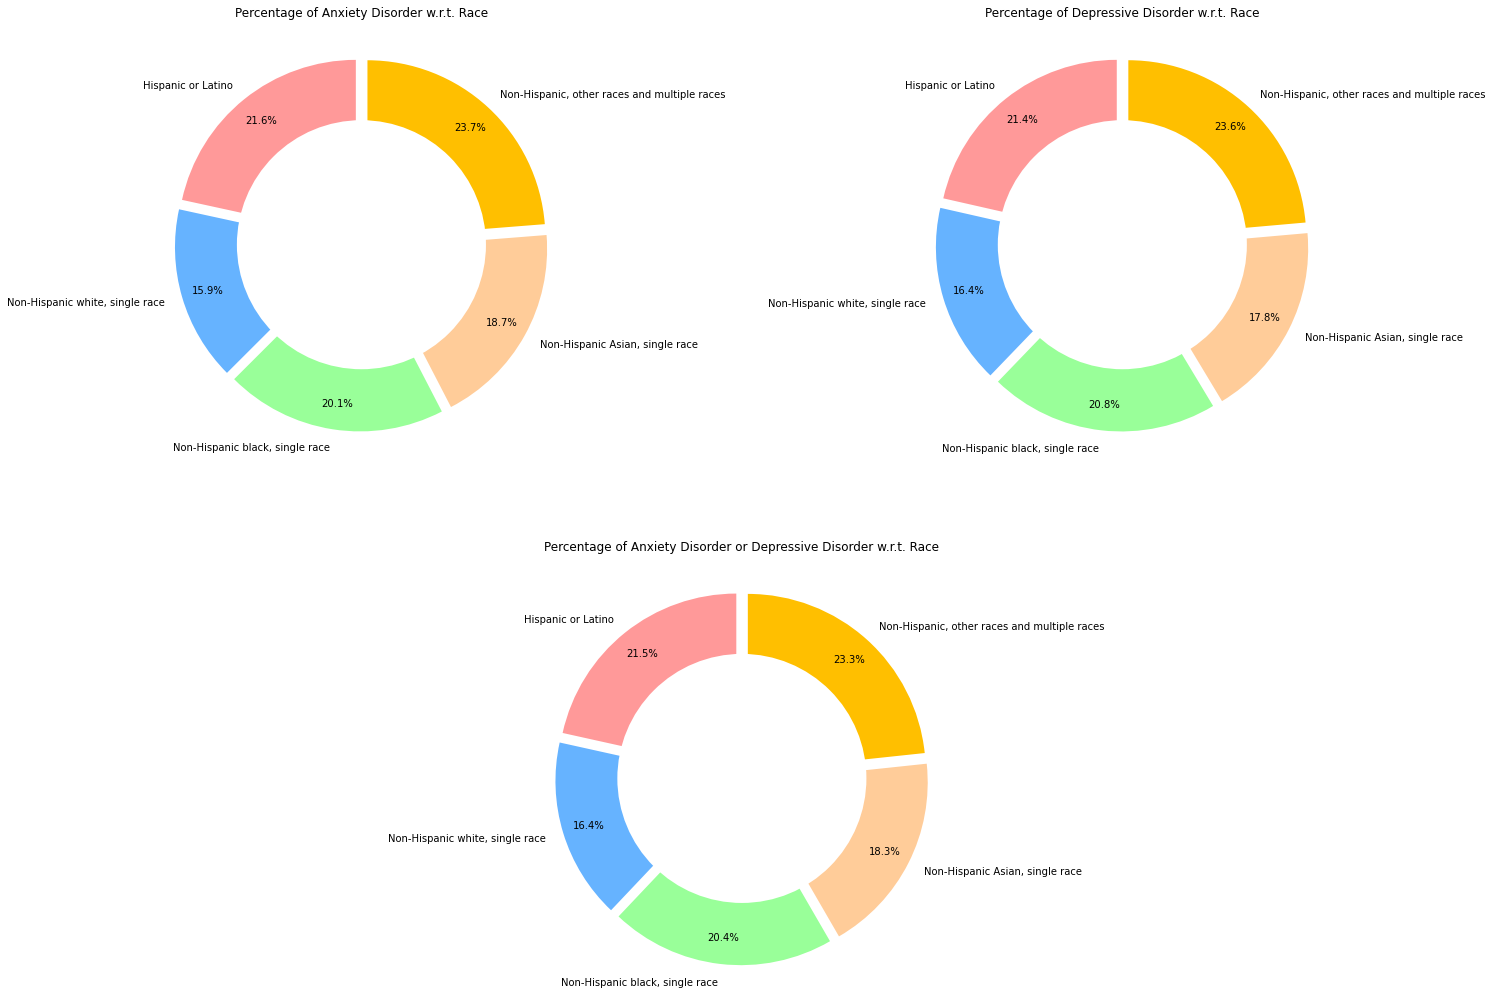

In [93]:
gs1 =gs.GridSpec(2, 2, width_ratios=[2,2], height_ratios=[2,2]) 
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,figsize=(25,18))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffbf00','#00ffff','#bfff00']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffbf00','#00ffff','#bfff00']
#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
p1= plt.subplot(gs1[0])
p01 = plt.pie(race1, colors = colors, labels=race_label2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
p01 = plt.gcf()
# p01.add_patch(centre_circle)
p01.gca().add_artist(centre_circle1)
plt.title("Percentage of Anxiety Disorder w.r.t. Race")


# race2=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup")["value"].mean()
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
p2= plt.subplot(gs1[1])
p02=plt.pie(race2, colors = colors, labels=race_label2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
p02 = plt.gcf()
p02.gca().add_artist(centre_circle2)
plt.title("Percentage of Depressive Disorder w.r.t. Race")

centre_circle3 = plt.Circle((0,0),0.70,fc='white')
p3= plt.subplot(gs1[2:4])
p03 = plt.pie(race3, colors = colors, labels=race_label3, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
p03 = plt.gcf()
p03.gca().add_artist(centre_circle3)
plt.title("Percentage of Anxiety Disorder or Depressive Disorder w.r.t. Race")



### 8.2 Mental Health v/s  Age Group <a id=section802></a>

In [94]:
ms1 = mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder')&(mentalState_dataframe['groups']=='By Age')].groupby("subgroup", as_index=False)["value"].mean()
ms1['value'] = ms1['value'].apply(np.ceil)
ms2 = mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Age')].groupby("subgroup", as_index=False)["value"].mean()
ms2['value'] = ms2['value'].apply(np.ceil)
ms3 = mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder or Depressive Disorder') & (mentalState_dataframe['groups']=='By Age')].groupby("subgroup", as_index=False)["value"].mean()
ms3['value'] = ms3['value'].apply(np.ceil)

In [95]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=ms1['subgroup'],
    y=ms1['value'],
    name='Symptoms of Anxiety Disorder',
    marker_color='#49255c', text= ms1['value'],textposition='auto'
))

fig.add_trace(go.Bar(
    x=ms2['subgroup'],
    y=ms2['value'],
    name='Depressive Disorder',
    marker_color='#ce3e5c', text= ms2['value'], textposition='auto' 
))

fig.add_trace(go.Bar(
    x=ms3['subgroup'],
    y=ms3['value'],
    name='Anxiety or Depressive Disorder',
    marker_color='#ffa600', text= ms3['value'], textposition='auto' 
))

fig.update_layout(barmode = 'stack',margin=dict(l=30, r=30, t=30, b=30),
    title={'text': "Mental Health v/s Age Group",'y':1,'x':0.38,'xanchor': 'center', 'yanchor': 'top'})

fig.show()

### 8.3 Mental Health Based on Age and Ethnicity <a id=section803></a>

In [96]:
age=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder') & (mentalState_dataframe['groups']=='By Age')].groupby("subgroup", as_index = False)["value"].mean()
race=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Race/Hispanic ethnicity')].groupby("subgroup", as_index = False)["value"].mean()

In [97]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=("Symptoms of Anxiety Disorder vs Age","Symptoms of Depressive Disorder vs Ethnicity"))

fig.add_trace(go.Bar(x=age["subgroup"],y=age["value"],
                    marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=race["subgroup"],y=race["value"],
                    marker=dict(color=[2, 3, 5], coloraxis="coloraxis")),
              1, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title={'text': "Mental Health Based on Age and Ethnicity",'y':0.95,'x':0.45,'xanchor': 'center', 'yanchor': 'top'})
fig.show()

### 8.4 Mental Health w.r.t. Education Level <a id=section804></a>

In [98]:
education_totals1=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder') & (mentalState_dataframe['groups']=='By Education')].groupby("subgroup", as_index=False)["value"].mean()
education_totals1['value'] = education_totals1['value'].apply(np.ceil)

education_totals2=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Anxiety Disorder or Depressive Disorder') & (mentalState_dataframe['groups']=='By Education')].groupby("subgroup",as_index=False)["value"].mean()
education_totals2['value'] = education_totals2['value'].apply(np.ceil)

education_totals3=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By Education')].groupby("subgroup",as_index=False)["value"].mean()
education_totals3['value'] = education_totals3['value'].apply(np.ceil)

In [99]:
#Creating Bar plots using plotly
fig = go.Figure()
fig.add_trace(go.Bar(
    x=education_totals1["subgroup"],
    y=education_totals1["value"],
    name='Symptoms of Anxiety Disorder',
    marker_color='#CD853F', text= education_totals1["value"],
            textposition='auto'
))
fig.add_trace(go.Bar(
   x=education_totals2["subgroup"],
    y=education_totals2["value"],
    name='Symptoms of Anxiety Disorder or Depressive Disorder',
    marker_color='silver', text= education_totals2["value"], textposition='auto'
))
fig.add_trace(go.Bar(
   x=education_totals3["subgroup"],
    y=education_totals3["value"],
    name='Symptoms of Depressive Disorder',
    marker_color='gold', text= education_totals3["value"], textposition='auto'
))

fig.update_layout(barmode = 'group',
    title={'text': "Comparison of Indicators w.r.t Education Level",'y':0.9,'x':0.45,'xanchor': 'center', 'yanchor': 'top'})

fig.show()

### 8.5 Mental Health w.r.t US States <a id=section805></a>

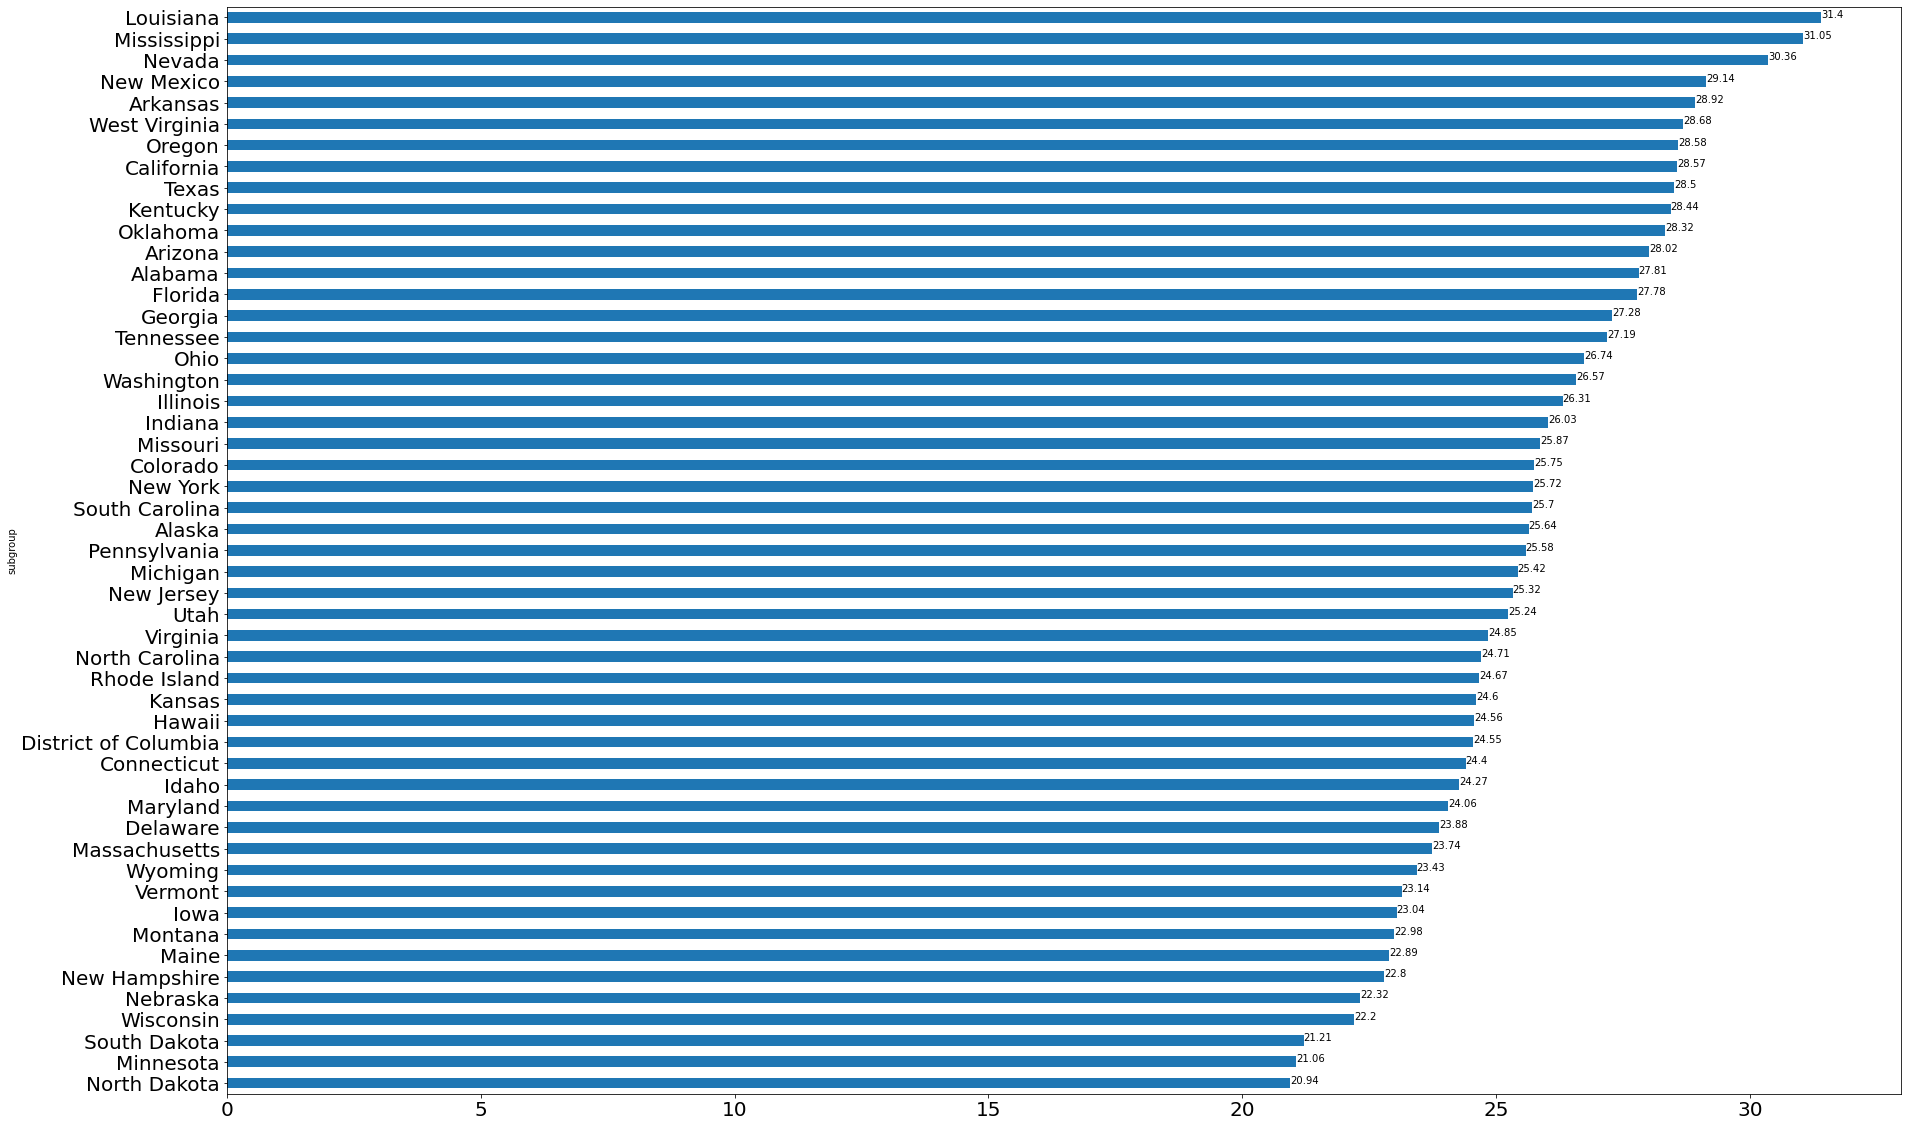

In [100]:
state_totals=mentalState_dataframe[(mentalState_dataframe['indicator']=='Symptoms of Depressive Disorder') & (mentalState_dataframe['groups']=='By State')].groupby("subgroup")["value"].mean().sort_values()
plt.rcParams["figure.figsize"] = (30,20)
state_totals.plot(kind="barh", fontsize=20,label='By State')

for index, value in enumerate(state_totals):
    plt.text(value, index, str(round(value,2)))

### 8.6 Mental Health Based on Gender <a id=section806></a>

In [101]:
male_total = mentalState_dataframe[(mentalState_dataframe['groups']=='By Sex') & (mentalState_dataframe['subgroup']=='Male')].groupby("indicator", as_index= False)["value"].mean()
male_total['value'] = male_total['value'].apply(np.ceil)
female_total = mentalState_dataframe[(mentalState_dataframe['groups']=='By Sex') & (mentalState_dataframe['subgroup']=='Female')].groupby("indicator",as_index= False)["value"].mean()
female_total['value'] = female_total['value'].apply(np.ceil)

In [102]:

#Creating Bar plots using plotly
fig = go.Figure()
fig.add_trace(go.Bar(
    x=male_total["indicator"],
    y=male_total["value"],
    name='Male',
    marker_color='#2e2f5c', text= male_total["value"],
            textposition='auto'
))
fig.add_trace(go.Bar(
    x=female_total["indicator"],
    y=female_total["value"],
    name='Female',
    marker_color='#c7416d', text= female_total["value"], textposition='auto'
))


fig.update_layout(barmode = 'group',
    title={'text': "Mental Health based on Gender",'y':0.9,'x':0.45,'xanchor': 'center', 'yanchor': 'top'})

fig.show()